# Homework week 2

## Preparation

In [281]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [282]:
# Get data for homework
import requests

url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv'
response = requests.get(url)

if response.status_code == 200:
    with open('housing.csv', 'wb') as file:
        file.write(response.content)
else:
    print("Download failed.")

In [283]:
# EDA - load data
df = pd.read_csv('housing.csv')
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


<Axes: xlabel='median_house_value', ylabel='Count'>

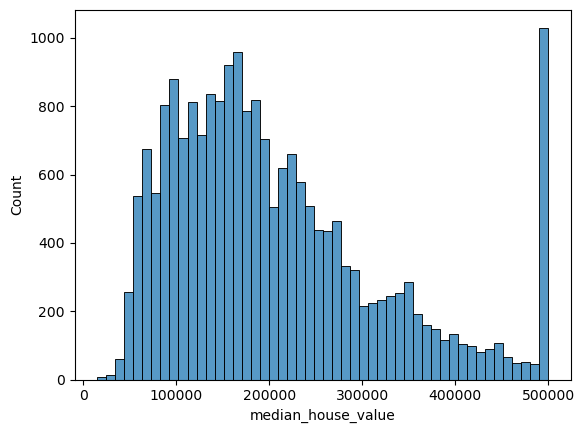

In [284]:
# EDA - Explore median_house_value
sns.histplot(df.median_house_value, bins = 50)

In [285]:
# Filter data to only keep records where `ocean_proximity` is either `<1H OCEAN` or `INLAND`

# First check uniques to ensure they match
df['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [286]:
# Now the names have been confirmed we can filter
df = df[(df['ocean_proximity'] == '<1H OCEAN') | (df['ocean_proximity'] == 'INLAND')]
# Check to ensure it worked properly
df['ocean_proximity'].unique()

array(['<1H OCEAN', 'INLAND'], dtype=object)

## Question 1  
Which feature has missing values?

In [287]:
# Check for nulls
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

## Question 2  
What's the median for variable 'population'?

In [288]:
# Get median of `population`
df['population'].median()

1195.0

## Prepare and split the dataset

In [289]:
# Check size of df and set to n
n = len(df)

# Get count of train/val/test 60%/20%/20%
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - (n_val + n_test)

# Validate counts
n_train, n_val, n_test

(9413, 3137, 3137)

In [290]:
# Prepare index to ensure data is shuffled
idx = np.arange(n)

# Set seed to 42
np.random.seed(42)
# Shuffle
np.random.shuffle(idx)

In [291]:
# Set dataframes to the values with seed index to allow for shuffling
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val:]]

# Check lengths
len(df_train), len(df_val), len(df_test)

(9413, 3137, 3137)

In [292]:
# The indexes are random now but we can reset them since they're already split
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [293]:
# Apply the log transformation `np.log1p()` to the target variable `median_house_value`
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

In [294]:
# This was not mentioend but we must remove the targets from the dataframes to avoid overtraining
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [295]:
# Remove `ocean_proximity` since it is not used
del df_train['ocean_proximity']
del df_val['ocean_proximity']
del df_test['ocean_proximity']

## Question 3  
- Deal with the missing values from `total_bedrooms` by either filling with 0 or the mean  
- Run a linear regression and test which results in a better RMSE rounded to 2 decimals `round(score, 2)`

In [296]:
# Define function to train a linear regression model

def train_linear_regression(X, y, r=0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [297]:
# Define function to calculate the RMSE

def rmse(y_true, y_pred):
    error = y_true - y_pred
    mse = (error ** 2).mean()
    return np.sqrt(mse)

### Filling `total_bedrooms` with 0 option

In [298]:
# Copy dataframe
df_train_zero = df_train.copy()

# Replace missing values with 0
df_train_zero['total_bedrooms'].fillna(0, inplace=True)
# Check that there are no missing values left
df_train_zero.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

### Filling `total_bedrooms` with mean option

In [299]:
# Copy dataframe
df_train_mean = df_train.copy()

# Get mean
mean_total_bedrooms = df_train_mean['total_bedrooms'].mean()
# Replace missing values with the mean
df_train_mean['total_bedrooms'].fillna(mean_total_bedrooms, inplace=True)
# Check that there are no missing values left
df_train_mean.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

### The validation sets will still have missing values which will cause issues and needs temporarily fixed

In [300]:
# Replace missing values in the validation set with 0 (for the 'fill with 0' model)
df_val_zero = df_val.copy()
df_val_zero['total_bedrooms'].fillna(0, inplace=True)

# Replace missing values in the validation set with the mean (for the 'fill with mean' model)
df_val_mean = df_val.copy()
mean_total_bedrooms = df_val_mean['total_bedrooms'].mean()
df_val_mean['total_bedrooms'].fillna(mean_total_bedrooms, inplace=True)

### Going forward with comparison in tandem

In [301]:
# Convert dataframe to numpy array
X_train_zero = df_train_zero.values
X_train_mean = df_train_mean.values

In [302]:
# Train linear regression model
w0_zero, w_zero = train_linear_regression(X_train_zero, y_train, r=0)
w0_mean, w_mean = train_linear_regression(X_train_mean, y_train, r=0)

In [303]:
# Apply the trained models to the validation dataset
X_val_zero = df_val_zero.values
X_val_mean = df_val_mean.values

In [304]:
# Create prediction
y_pred_zero = w0_zero + X_val_zero.dot(w_zero)
y_pred_mean = w0_mean + X_val_mean.dot(w_mean)

In [305]:
# Calculate RMSE
rmse_zero = rmse(y_val, y_pred_zero)
rmse_mean = rmse(y_val, y_pred_mean)

In [306]:
# Print rounded RMSE
round(rmse_zero, 2), round(rmse_mean, 2)

(0.34, 0.34)

## Question 4  
- Moving forward with the fill with 0 option
- Try different values of `r` `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`
- Evaluate the RMSE rounded to 2 digits and determine whith `r` gives the best value

In [307]:
# Replace missing values with 0
df_train['total_bedrooms'].fillna(0, inplace=True)
# Check that there are no missing values left
df_train.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

In [308]:
# Replace missing values in the validation set with 0 (for the 'fill with 0' model)
df_train['total_bedrooms'].fillna(0, inplace=True)
df_val['total_bedrooms'].fillna(0, inplace=True)
df_test['total_bedrooms'].fillna(0, inplace=True)

In [309]:
# check the RMSE for each value of r given to tune the model

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:

    #train the model with the training dataset
    X_train = df_train.values
    w0, w = train_linear_regression(X_train, y_train, r=r)

    #validate the model with validation dataset
    X_val = X_val = df_val.values
    y_pred = w0 + X_val.dot(w)

    #assess via the RMSE
    score = rmse(y_val, y_pred)

    print (r, w0, round(score, 2))

0 -9.763249476820075 0.34
1e-06 -9.763228829930881 0.34
0.0001 -9.761185234413102 0.34
0.001 -9.742646248260925 0.34
0.01 -9.561056192183965 0.34
0.1 -8.058889768739107 0.34
1 -3.1331542782254003 0.34
5 -0.8410867974044524 0.35
10 -0.4381172314974181 0.35


## Question 5
- We used seed 42 now let us now try different seed values `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`
- For each seed do the train/validation/test split with 60%/20%/20% distribution
- Fill the missing values with 0 and train the model without regularization
- For each seed evaluate the model on the validation dataset and collect the RMSE scores
- What's the standard devision of all the scores? use `np.std` to calculate standard deviation
- Round the result to 3 decimal digits `round(std, 3)`

In [313]:
# Define a list of seed values to iterate over
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Initialize an empty list to collect RMSE scores
rmse_scores = []

for seed in seed_values:
    # Set seed for reproducibility
    np.random.seed(seed)
    
    # Perform train/validation/test split with a 60%/20%/20% distribution
    idx = np.arange(len(df))
    np.random.shuffle(idx)
    n_train = int(0.6 * len(df))
    n_val = int(0.2 * len(df))
    n_test = len(df) - n_train - n_val
    idx_train = idx[:n_train]
    idx_val = idx[n_train:n_train + n_val]
    idx_test = idx[n_train + n_val:]
    
    # Create DataFrames for train, validation, and test sets
    df_train = df.iloc[idx_train]
    df_val = df.iloc[idx_val]
    df_test = df.iloc[idx_test]
    
    # Apply log transformation to target variables
    y_train = np.log1p(df_train['median_house_value'].values)
    y_val = np.log1p(df_val['median_house_value'].values)
    y_test = np.log1p(df_test['median_house_value'].values)
    
    # Remove the target variable from DataFrames
    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']

    # Remove 'ocean_proximity'
    del df_train['ocean_proximity']
    del df_val['ocean_proximity']
    del df_test['ocean_proximity']

    # Fill 'total_bedrooms' with 0
    df_train['total_bedrooms'].fillna(0, inplace=True)
    df_val['total_bedrooms'].fillna(0, inplace=True)
    df_test['total_bedrooms'].fillna(0, inplace=True)
    
    # Convert DataFrames to numpy arrays
    X_train = df_train.values
    X_val = df_val.values
    
    # Train a linear regression model without regularization
    w0, w = train_linear_regression(X_train, y_train, r=0)
    
    # Predict on the validation set
    y_pred = w0 + X_val.dot(w)
    
    # Calculate RMSE for this seed
    rmse_score = rmse(y_val, y_pred)
    
    # Append RMSE score to the list
    rmse_scores.append(rmse_score)

    # Calculate the standard deviation of RMSE scores
    std_dev = np.std(rmse_scores)

    # Round the standard deviation result to 3 decimal digits
    std_dev_rounded = round(std_dev, 4)

    print(std_dev_rounded)

0.0
0.0
0.0003
0.0026
0.0026
0.0033
0.0031
0.0044
0.0056
0.0056


/tmp/ipykernel_36981/2267391770.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['total_bedrooms'].fillna(0, inplace=True)
/tmp/ipykernel_36981/2267391770.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['total_bedrooms'].fillna(0, inplace=True)
/tmp/ipykernel_36981/2267391770.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['total_bedrooms'].fillna(0, inplace=True)


## Question 6  
- Split the dataset like previously and use seed `9`
- Combine train and validation datasets
- Fill the missing values with 0 and train a model with `r=0.001`
- What is the RMSE on the test dataset?

In [316]:
# Set the random seed to 9 for reproducibility
np.random.seed(9)

# Perform train/validation/test split with a 60%/20%/20% distribution
idx = np.arange(len(df))
np.random.shuffle(idx)
n_train = int(0.6 * len(df))
n_val = int(0.2 * len(df))
n_test = len(df) - n_train - n_val
idx_train = idx[:n_train]
idx_val = idx[n_train:n_train + n_val]
idx_test = idx[n_train + n_val:]

# Create DataFrames for train, validation, and test sets
df_train = df.iloc[idx_train]
df_val = df.iloc[idx_val]
df_test = df.iloc[idx_test]

# Combine train and validation datasets
df_train_val = pd.concat([df_train, df_val], axis=0)

# Apply log transformation to target variables
y_train_val = np.log1p(df_train_val['median_house_value'].values)
y_test = np.log1p(df_test['median_house_value'].values)

# Remove the target variable from DataFrames
del df_train_val['median_house_value']
del df_test['median_house_value']

# Remove 'ocean_proximity'
del df_train_val['ocean_proximity']
del df_test['ocean_proximity']

# Fill 'total_bedrooms' with 0
df_train_val['total_bedrooms'].fillna(0, inplace=True)
df_test['total_bedrooms'].fillna(0, inplace=True)

# Convert DataFrames to numpy arrays
X_train_val = df_train_val.values
X_test = df_test.values

# Train a linear regression model with r=0.001
w0, w = train_linear_regression(X_train_val, y_train_val, r=0.001)

# Predict on the test set
y_pred_test = w0 + X_test.dot(w)

# Calculate RMSE on the test dataset
rmse_test = rmse(y_test, y_pred_test)

print(rmse_test)

0.33495446249514166


/tmp/ipykernel_36981/4207028233.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['total_bedrooms'].fillna(0, inplace=True)
